In [2]:
pip install gradio

In [3]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import gradio as gr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [4]:
# Define classes and their labels
classes = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [5]:
# Load and preprocess the dataset
X = []
Y = []
for cls, label in classes.items():
    pth = f"/content/drive/MyDrive/lessdata (1)/Training/{cls}"
    if not os.path.exists(pth):
        print(f"Warning: Directory not found: {pth}")
        continue

    for filename in os.listdir(pth):
        img = cv2.imread(os.path.join(pth, filename), 0)
        if img is not None:
            img = cv2.resize(img, (200, 200))
            X.append(img)  # Keep the image as a 2D array for CNN
            Y.append(label)
        else:
            print(f"Warning: Failed to load image: {os.path.join(pth, filename)}")

X = np.array(X)
Y = np.array(Y)

In [6]:
# Print unique classes and their counts after loading
unique, counts = np.unique(Y, return_counts=True)
print(f"Classes after loading: {unique}, Counts: {counts}")

Classes after loading: [0 1 2 3], Counts: [400 460 395 400]


In [7]:
# Split the dataset into training and testing sets with stratification
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=10, test_size=0.2, stratify=Y)

In [8]:
# Reshape the training and testing data for CNN
xtrain_cnn = xtrain.reshape(xtrain.shape[0], 200, 200, 1)  # Add channel dimension
xtest_cnn = xtest.reshape(xtest.shape[0], 200, 200, 1)  # Add channel dimension

In [9]:
# Normalize the pixel values
xtrain_cnn = xtrain_cnn.astype('float32') / 255.0
xtest_cnn = xtest_cnn.astype('float32') / 255.0

In [10]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))  # Output layer for the number of classes

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Train the CNN model for a single epoch
model.fit(xtrain_cnn, ytrain, epochs=20, batch_size=32, verbose=0)
test_loss, test_accuracy = model.evaluate(xtest_cnn, ytest, verbose=0)
print(f'CNN Test Accuracy: {test_accuracy:.4f}')


CNN Test Accuracy: 0.7553


In [13]:
# Train the SVM model
# Flatten the images for SVM
xtrain_svm = xtrain.reshape(xtrain.shape[0], -1)  # Flatten for SVM
xtest_svm = xtest.reshape(xtest.shape[0], -1)  # Flatten for SVM

In [14]:
# Import necessary library
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the SVM model
svm_model = SVC()  # Initialize SVM model
svm_model.fit(xtrain_svm, ytrain)  # Train the SVM model

# Evaluate the SVM model and track accuracy
svm_accuracy = accuracy_score(ytest, svm_model.predict(xtest_svm))
print(f'SVM Test Accuracy: {svm_accuracy:.4f}')

SVM Test Accuracy: 0.8218


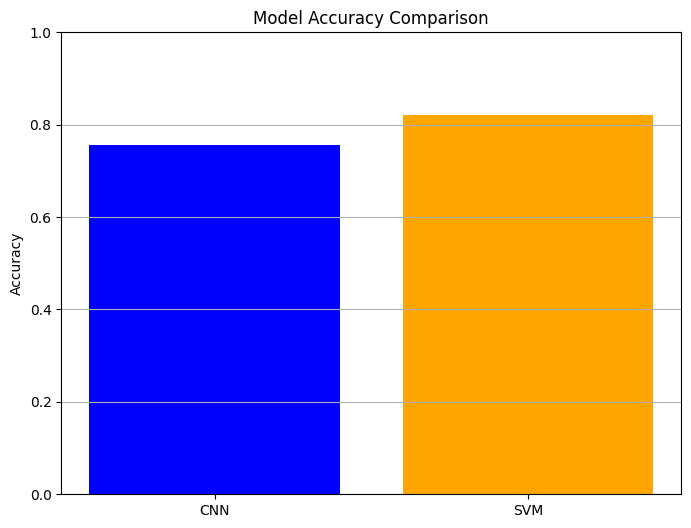

In [15]:
# Plot the accuracies of CNN and SVM as a bar chart
cnn_accuracy = test_accuracy  # CNN accuracy from the evaluation
svm_accuracy = svm_accuracy  # SVM accuracy from the evaluation

# Create a bar chart
plt.figure(figsize=(8, 6))
labels = ['CNN', 'SVM']
accuracies = [cnn_accuracy, svm_accuracy]

plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.show()

In [16]:
#from google.colab import drive
#drive.mount('/content/drive')

In [17]:
# Generate predictions for the test set
ytest_pred = model.predict(xtest_cnn)
ytest_pred_classes = np.argmax(ytest_pred, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


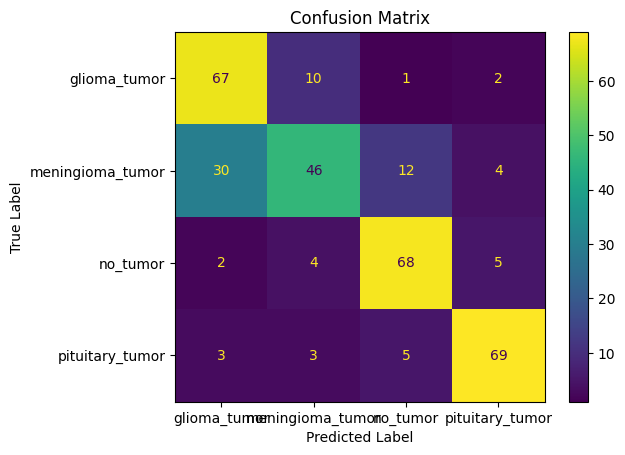

In [18]:
# Plot the confusion matrix
cm = confusion_matrix(ytest, ytest_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.keys()))
disp.plot()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [19]:
# Predict on a single image
def predict_tumor_class(image):
    img = cv2.resize(image, (200, 200))
    img_array = img.reshape(1, 200, 200, 1)  # Reshape for CNN
    img_array = img_array.astype('float32') / 255.0  # Normalize
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    dec = {0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}
    return dec[predicted_class]

In [20]:
 #Gradio interface function
def brain_tumor_classification(image):
    predicted_class = predict_tumor_class(image)
    return predicted_class

In [21]:

# Create the Gradio interface
iface = gr.Interface(
    fn=brain_tumor_classification,
    inputs=gr.Image(image_mode='L'),
    outputs=gr.Textbox(label="Predicted Tumor Class"),
    title="Brain Tumor Classification",
    description="Upload an image to classify the brain tumor type."
)



In [ ]:
# Launch the Gradio interface
print("Launching Gradio interface...")
iface.launch(debug=True)

Launching Gradio interface...
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://643992d876d241e9a8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
